## Threshold irradiance vs. pulse width and distance

Here we will replicate figure 3 of Foutz et al., 2012 for different model combos:

| Original | Replicated|
| - | - |
| ![Foutz et al., 2012 Figure 3](img/orig/foutz12_3.jpg) | ![Replication of Foutz et al., 2012 Figure 3](img/repl/foutz12_3.svg)|

In [26]:
%load_ext autoreload
%autoreload 2
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# matplotlib.style.use(['seaborn', 'seaborn-notebook', 'dark_background'])
matplotlib.style.use(['seaborn-paper'])
matplotlib.rcParams['font.sans-serif'] = "Open Sans"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We prepare a pandas dataframe in tidy format:

In [27]:
import pandas as pd
df = pd.DataFrame(columns=["name", "distance", "pulse_width", "threshold"])
df

,name,distance,pulse_width,threshold


We need to get the original data for comparison:

In [28]:
wpd_data = pd.read_csv('data/foutz12_3_wpd.csv')
wpd_data.head()

,1.5 mm,Unnamed: 1,1 mm,Unnamed: 3,0.5 mm,Unnamed: 5
0,X,Y,X,Y,X,Y
1,2.8036529680365296,2004.8387096774195,1.4155251141552503,2000,0.6392694063926934,2000
2,2.9132420091324196,1830.6451612903227,1.5981735159817338,1554.8387096774195,0.6849315068493147,1666.1290322580646
3,3.1050228310502277,1661.2903225806454,1.9726027397260264,1061.2903225806451,0.7853881278538806,1322.5806451612905
4,3.4063926940639266,1438.7096774193549,2.5114155251141543,679.0322580645161,0.8812785388127846,1032.258064516129


In [29]:
for i_col in [0, 2, 4]:
    for i_row in range(1, len(wpd_data)):
        if pd.isna(wpd_data.iloc[i_row, i_col]):
            continue
        df.loc[len(df)] = [
            "Foutz et al., 2012",
            wpd_data.columns[i_col],
            wpd_data.iloc[i_row, i_col],
            wpd_data.iloc[i_row, i_col + 1],
        ]
df.pulse_width = df.pulse_width.astype(float)
df.threshold = df.threshold.astype(float)


In [30]:
df.tail()

,name,distance,pulse_width,threshold
41,"Foutz et al., 2012",0.5 mm,4.365297,54.838710
42,"Foutz et al., 2012",0.5 mm,5.132420,40.322581
43,"Foutz et al., 2012",0.5 mm,5.707763,35.483871
44,"Foutz et al., 2012",0.5 mm,6.730594,11.290323
45,"Foutz et al., 2012",0.5 mm,9.990868,6.451613


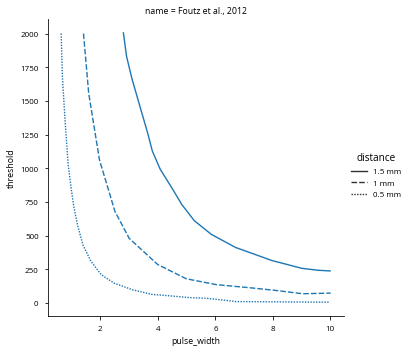

In [31]:
def plot_thresh(data):
    sns.relplot(
        data=data,
        kind="line",
        col='name',
        x="pulse_width",
        y="threshold",
        units="distance",
        style="distance",
        estimator=None,
    )

plot_thresh(df)

Looks right. Time to test the models.

In [32]:
from opto_val import lif, adex, get_Irr0_thres
import numpy as np

data_already_generated = True
if not data_already_generated:
    pulse_widths = np.arange(0.2, 10.2, 0.2)
    for ng_constructor in [lif, adex]:
        for simple_opto in [True, False]:
            for dist in [1.5, 1, 0.5]:
                ng = ng_constructor(1)
                Irr0_thres = get_Irr0_thres(pulse_widths, dist, ng, gain_factor=15, simple_opto=simple_opto)
                opsin_name = "Simple" if simple_opto else "Markov"
                name = f"{ng.name} + {opsin_name} opsin"
                df = pd.concat(
                    [
                        df,
                        pd.DataFrame(
                            {
                                "name": name,
                                "distance": f"{dist} mm",
                                "pulse_width": pulse_widths,
                                "threshold": Irr0_thres,
                            }
                        ),
                    ]
                )
    df = df.reset_index(drop=True)
    df.to_csv("data/thresholds.csv", index=False)
    df.tail()

We load the saved data here to skip the long simulation in the future.

And we tweak the model names to optimize for visualization:

In [33]:
df = pd.read_csv('data/thresholds.csv')
df.name = df.name.replace(regex=r'Foutz et al., 2012', value='Morphological HH neuron + Markov opsin')
df.name = df.name.replace(regex=r' \+ ', value='\n')
df.name = df.name.replace(regex=r'LIF', value='LIF neuron')
df.name = df.name.replace(regex=r'AdEx', value='AdEx neuron')
df.name = df.name.replace(regex=r'simple', value='Simple')
df

,name,distance,pulse_width,threshold
0,Morphological HH neuron\nMarkov opsin,1.5 mm,2.803653,2004.838710
1,Morphological HH neuron\nMarkov opsin,1.5 mm,2.913242,1830.645161
2,Morphological HH neuron\nMarkov opsin,1.5 mm,3.105023,1661.290323
3,Morphological HH neuron\nMarkov opsin,1.5 mm,3.406393,1438.709677
4,Morphological HH neuron\nMarkov opsin,1.5 mm,3.643836,1264.516129
...,...,...,...,...
641,AdEx neuron\nMarkov opsin,0.5 mm,9.200000,1.831055
642,AdEx neuron\nMarkov opsin,0.5 mm,9.400000,1.831055
643,AdEx neuron\nMarkov opsin,0.5 mm,9.600000,1.831055
644,AdEx neuron\nMarkov opsin,0.5 mm,9.800000,1.831055


## Figure

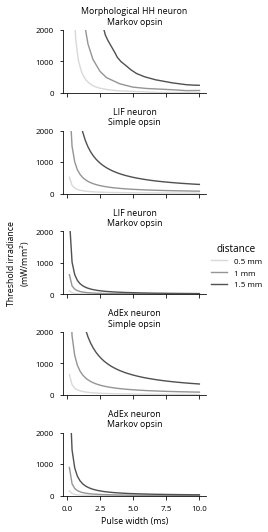

In [34]:
def plot_thresh(data, palette):
    g = sns.relplot(
        data=data,
        kind="line",
        row="name",
        x="pulse_width",
        y="threshold",
        hue="distance",
        hue_order=["0.5 mm", "1 mm", "1.5 mm"],
        estimator=None,
        height=1.5,
        aspect=2,
        palette=palette,
        legend=True,
    )
    g.set(ylim=(0, 2000))
    g.set_titles(row_template="{row_name}")
    return g


g = plot_thresh(
    df,
    palette='Greys',
)
g.set_axis_labels("", "")
g.axes[2, 0].set_ylabel("Threshold irradiance\n(mW/mm$^2$)")
g.axes[-1, 0].set_xlabel("Pulse width (ms)")
g.fig.savefig('img/fig/opto_thresh.svg', bbox_inches='tight')